In [3]:
import os
import pandas as pd
from ragas.metrics import answer_relevancy, answer_correctness, FactualCorrectness, SemanticSimilarity
from ragas import evaluate
from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper
from langchain.chat_models import ChatOpenAI
from langchain_localai import LocalAIEmbeddings
from datasets import Dataset
from dotenv import load_dotenv
import json

import json
import pandas as pd
import os
from datasets import Dataset
from tqdm import tqdm
import numpy as np

c:\Projekty_magister_sem3\magisterka\praca_magisterska\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
load_dotenv()
llm = ChatOpenAI(
    openai_api_base=os.getenv("OPENAI_API_BASE"), 
    openai_api_key=os.getenv("OPENAI_API_KEY"),              
    model_name=os.getenv("LLM_MODEL_NAME")          
)
llm = LangchainLLMWrapper(llm)

embedding = LocalAIEmbeddings(
    openai_api_base=os.getenv("EMBED_URL"), 
    openai_api_key=os.getenv("EMBED_TOKEN"), 
    model=os.getenv("EMBED_MODEL")
)
embedding = LangchainEmbeddingsWrapper(embedding)

/tmp/ipykernel_151903/1901439954.py:2: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import ChatOpenAI``.
  llm = ChatOpenAI(


# First Evaluation

In [ ]:
def start_evaluate(test_set_file, output_file):
    with open(test_set_file, 'r', encoding='utf-8') as file:
        data = json.load(file)

    if os.path.exists(output_file):
        existing_df = pd.read_csv(output_file)
    else:
        existing_df = pd.DataFrame(columns=[
            'user_input', 'response', 'reference',
            'answer_correctness', 'answer_relevancy'
        ])

    existing_df.fillna('', inplace=True)

    for idx, (q, a, g) in enumerate(zip(data['question'], data['answer'], data['ground_truth']), start=1):
        short_q = q[:50].replace('\n', ' ')
        print(f"[{idx}] Processing question: \"{short_q}...\"")
        if a == "x":
            print(f"[{idx}] Skipped (x in ans)")
            continue
        match = existing_df[
            (existing_df['user_input'] == q) &
            (existing_df['response'] == a) &
            (existing_df['reference'] == g)
        ]
        if not match.empty:
            existing_row = match.iloc[0]
            correctness = pd.to_numeric(existing_row['answer_correctness'], errors='coerce')
            relevancy = pd.to_numeric(existing_row['answer_relevancy'], errors='coerce')
            if (
                not pd.isna(correctness) and not pd.isna(relevancy) and
                correctness > 0.0 and relevancy > 0.0
            ):
                print(f"[{idx}] Skipped (already evaluated with valid metrics)")
                continue

        print(f"[{idx}] Running evaluation...")
        single_data = {
            "question": [q],
            "answer": [a],
            "ground_truth": [g]
        }
        single_dataset = Dataset.from_dict(single_data)

        try:
            results = evaluate(
                dataset=single_dataset,
                metrics=[answer_correctness, answer_relevancy],
                llm=llm,
                embeddings=embedding
            )
            row_df = results.to_pandas()
            print(f"[{idx}] Evaluation completed successfully.")
        except Exception as e:
            print(f"[{idx}] Evaluation error: {e}")
            row_df = pd.DataFrame([{
                'user_input': q,
                'response': a,
                'reference': g,
                'answer_correctness': 0.0,
                'answer_relevancy': 0.0
            }])

        existing_df = pd.concat([existing_df, row_df], ignore_index=True)
        existing_df.drop_duplicates(
            subset=['user_input', 'response', 'reference'], keep='last', inplace=True
        )
        existing_df.to_csv(output_file, index=False)

    print(f"All done — results saved to: {output_file}")


## Evaluation with meta-llama/llama-4-scout-17b-16e-instruct

In [13]:
llm = ChatOpenAI(
    openai_api_base=os.getenv("OPENAI_API_BASE"), 
    openai_api_key=os.getenv("OPENAI_API_KEY"),              
    model_name="meta-llama/llama-4-scout-17b-16e-instruct"         
)
llm = LangchainLLMWrapper(llm)

embedding = LocalAIEmbeddings(
    openai_api_base=os.getenv("EMBED_URL"), 
    openai_api_key=os.getenv("EMBED_TOKEN"), 
    model=os.getenv("EMBED_MODEL")
)
embedding = LangchainEmbeddingsWrapper(embedding)

In [14]:
test_set_file = './test_data/study_rules/test_set_method1_lightrag_hybrid.json'
output_file = './results/study_rules/method1_lightrag_hybrid.csv'

#results = start_evaluate(test_set_file, output_file)

df_lr_hybrid = pd.read_csv(output_file)
print(f"FILE: {output_file}")
print("Average answer correctness:", df_lr_hybrid['answer_correctness'].mean())
print("Average answer relevancy:", df_lr_hybrid['answer_relevancy'].mean())

FILE: ./results/study_rules/method1_lightrag_hybrid.csv
Average answer correctness: 0.5122069836697539
Average answer relevancy: 0.6982478951966491


In [15]:
test_set_file = './test_data/study_rules/test_set_method1_lightrag_local.json'
output_file = './results/study_rules/method1_lightrag_local.csv'

#results = start_evaluate(test_set_file, output_file)

df_lr_local = pd.read_csv(output_file)
print(f"FILE: {output_file}")
print("Average answer correctness:", df_lr_local['answer_correctness'].mean())
print("Average answer relevancy:", df_lr_local['answer_relevancy'].mean())

FILE: ./results/study_rules/method1_lightrag_local.csv
Average answer correctness: 0.4249733737262503
Average answer relevancy: 0.6681967775090379


In [16]:
test_set_file = './test_data/study_rules/test_set_method2_graphrag_drift.json'
output_file = './results/study_rules/method2_graphrag_drift.csv'

#results = start_evaluate(test_set_file, output_file)

df_gr_drift = pd.read_csv(output_file)
print(f"FILE: {output_file}")
print("Average answer correctness:", df_gr_drift['answer_correctness'].mean())
print("Average answer relevancy:", df_gr_drift['answer_relevancy'].mean())

FILE: ./results/study_rules/method2_graphrag_drift.csv
Average answer correctness: 0.3500237400348909
Average answer relevancy: 0.7774822101039724


In [17]:
test_set_file = './test_data/study_rules/test_set_naive_rag.json'
output_file = './results/study_rules/naive_rag.csv'

#results = start_evaluate(test_set_file, output_file)

df_naive = pd.read_csv(output_file)
print(f"FILE: {output_file}")
print("Average answer correctness:", df_naive['answer_correctness'].mean())
print("Average answer relevancy:", df_naive['answer_relevancy'].mean())

FILE: ./results/study_rules/naive_rag.csv
Average answer correctness: 0.5506225438324175
Average answer relevancy: 0.7527904156645951


In [ ]:
test_set_file = './test_data/study_rules/test_set_naive_rag_small_top_k.json'
output_file = './results/study_rules/naive_rag_small_top_k.csv'

#results = start_evaluate(test_set_file, output_file)

df_naive_small_k = pd.read_csv(output_file)
print(f"FILE: {output_file}")
print("Average answer correctness:", df_naive_small_k['answer_correctness'].mean())
print("Average answer relevancy:", df_naive_small_k['answer_relevancy'].mean())

FILE: ./results/study_rules/naive_rag_small_top_k.csv
Average answer correctness: 0.5652947016792146
Average answer relevancy: 0.6714817258125219


## Evaluation with deepseek-r1-distill-llama-70b

In [24]:
llm = ChatOpenAI(
    openai_api_base=os.getenv("OPENAI_API_BASE"), 
    openai_api_key=os.getenv("OPENAI_API_KEY"),              
    model_name="deepseek-r1-distill-llama-70b"         
)
llm = LangchainLLMWrapper(llm)

embedding = LocalAIEmbeddings(
    openai_api_base=os.getenv("EMBED_URL"), 
    openai_api_key=os.getenv("EMBED_TOKEN"), 
    model=os.getenv("EMBED_MODEL")
)
embedding = LangchainEmbeddingsWrapper(embedding)

In [20]:
test_set_file = './test_data/study_rules/test_set_method1_lightrag_hybrid.json'
output_file = './results/study_rules/method1_lightrag_hybrid_deepseek.csv'

#results = start_evaluate(test_set_file, output_file)

df_lr_hybrid_deepseek = pd.read_csv(output_file)
print(f"FILE: {output_file}")
print("Average answer correctness:", df_lr_hybrid_deepseek['answer_correctness'].mean())
print("Average answer relevancy:", df_lr_hybrid_deepseek['answer_relevancy'].mean())

FILE: ./results/study_rules/method1_lightrag_hybrid_deepseek.csv
Average answer correctness: 0.49797992824280307
Average answer relevancy: 0.7349126593819586


In [21]:
test_set_file = './test_data/study_rules/test_set_method1_lightrag_local.json'
output_file = './results/study_rules/method1_lightrag_local_deepseek.csv'

#results = start_evaluate(test_set_file, output_file)

df_lr_local_deepseek = pd.read_csv(output_file)
print(f"FILE: {output_file}")
print("Average answer correctness:", df_lr_local_deepseek['answer_correctness'].mean())
print("Average answer relevancy:", df_lr_local_deepseek['answer_relevancy'].mean())

FILE: ./results/study_rules/method1_lightrag_local_deepseek.csv
Average answer correctness: 0.4016634365973334
Average answer relevancy: 0.5804095482320186


In [22]:
test_set_file = './test_data/study_rules/test_set_method2_graphrag_drift.json'
output_file = './results/study_rules/method2_graphrag_drift_deepseek.csv'

#results = start_evaluate(test_set_file, output_file)

df_gr_drift_deepseek = pd.read_csv(output_file)
print(f"FILE: {output_file}")
print("Average answer correctness:", df_gr_drift_deepseek['answer_correctness'].mean())
print("Average answer relevancy:", df_gr_drift_deepseek['answer_relevancy'].mean())

FILE: ./results/study_rules/method2_graphrag_drift_deepseek.csv
Average answer correctness: 0.39543015771151035
Average answer relevancy: 0.7339491973490562


In [27]:
test_set_file = './test_data/study_rules/test_set_naive_rag.json'
output_file = './results/study_rules/naive_rag_deepseek.csv'

#results = start_evaluate(test_set_file, output_file)

df_naive_deepseek = pd.read_csv(output_file)
print(f"FILE: {output_file}")
print("Average answer correctness:", df_naive_deepseek['answer_correctness'].mean())
print("Average answer relevancy:", df_naive_deepseek['answer_relevancy'].mean())

FILE: ./results/study_rules/naive_rag_deepseek.csv
Average answer correctness: 0.5585839181481368
Average answer relevancy: 0.7402449547731885


In [30]:
test_set_file = './test_data/study_rules/test_set_naive_rag_small_top_k.json'
output_file = './results/study_rules/naive_rag_small_top_k_deepseek.csv'

#results = start_evaluate(test_set_file, output_file)

df_naive_small_k_deepseek = pd.read_csv(output_file)
print(f"FILE: {output_file}")
print("Average answer correctness:", df_naive_small_k_deepseek['answer_correctness'].mean())
print("Average answer relevancy:", df_naive_small_k_deepseek['answer_relevancy'].mean())

FILE: ./results/study_rules/naive_rag_small_top_k_deepseek.csv
Average answer correctness: 0.5452149662099343
Average answer relevancy: 0.6653694964764589


# Second Evaluation

In [4]:
def start_evaluate_2(test_set_file, output_file):
    with open(test_set_file, 'r', encoding='utf-8') as file:
        data = json.load(file)

    if os.path.exists(output_file):
        existing_df = pd.read_csv(output_file)
    else:
        existing_df = pd.DataFrame(columns=[
            'user_input', 'response', 'reference',
            'answer_correctness', 'answer_relevancy', 'factual_correctness(mode=f1)',
            'factual_correctness(mode=recall)', 'semantic_similarity'
        ])

    existing_df.fillna('', inplace=True)

    for idx, (q, a, g) in enumerate(zip(data['question'], data['answer'], data['ground_truth']), start=1):
        short_q = q[:50].replace('\n', ' ')
        print(f"[{idx}] Processing question: \"{short_q}...\"")
        if a == "x":
            print(f"[{idx}] Skipped (x in ans)")
            continue
        match = existing_df[
            (existing_df['user_input'] == q) &
            (existing_df['response'] == a) &
            (existing_df['reference'] == g)
        ]
        if not match.empty:
            existing_row = match.iloc[0]
            correctness = pd.to_numeric(existing_row['answer_correctness'], errors='coerce')
            relevancy = pd.to_numeric(existing_row['answer_relevancy'], errors='coerce')
            factual_correctness = pd.to_numeric(existing_row['factual_correctness(mode=f1)'], errors='coerce')
            factual_correctness_recall = pd.to_numeric(existing_row['factual_correctness(mode=recall)'], errors='coerce')
            semantic_similarity = pd.to_numeric(existing_row['semantic_similarity'], errors='coerce')
            if (
                not pd.isna(correctness) and not pd.isna(relevancy) and not pd.isna(factual_correctness) 
                and not pd.isna(factual_correctness_recall) and not pd.isna(semantic_similarity) and 
                correctness > 0.0 and relevancy > 0.0 and factual_correctness > 0.0  and factual_correctness_recall > 0.0
                and semantic_similarity > 0.0
            ):
                print(f"[{idx}] Skipped (already evaluated with valid metrics)")
                continue

        print(f"[{idx}] Running evaluation...")
        single_data = {
            "question": [q],
            "answer": [a],
            "ground_truth": [g]
        }
        single_dataset = Dataset.from_dict(single_data)

        try:
            results = evaluate(
                dataset=single_dataset,
                metrics=[answer_correctness, answer_relevancy, FactualCorrectness(),
                         FactualCorrectness(mode="recall"), SemanticSimilarity()],
                llm=llm,
                embeddings=embedding
            )
            # results = evaluate(
            #     dataset=single_dataset,
            #     metrics=[answer_correctness, answer_relevancy, FactualCorrectness(atomicity="high", coverage="high"),
            #              FactualCorrectness(mode="recall",atomicity="high", coverage="high"), SemanticSimilarity()],
            #     llm=llm,
            #     embeddings=embedding
            # )
            print(results)
            row_df = results.to_pandas()
            print(f"[{idx}] Evaluation completed successfully.")
        except Exception as e:
            print(f"[{idx}] Evaluation error: {e}")
            row_df = pd.DataFrame([{
                'user_input': q,
                'response': a,
                'reference': g,
                'answer_correctness': 0.0,
                'answer_relevancy': 0.0,
                'factual_correctness(mode=f1)': 0.0,
                'factual_correctness(mode=recall)': 0.0,
                'semantic_similarity': 0.0
            }])

        existing_df = pd.concat([existing_df, row_df], ignore_index=True)
        existing_df.drop_duplicates(
            subset=['user_input', 'response', 'reference'], keep='last', inplace=True
        )
        existing_df.to_csv(output_file, index=False)

    print(f"All done — results saved to: {output_file}")

In [5]:
llm = ChatOpenAI(
    openai_api_base=os.getenv("OPENAI_API_BASE"), 
    openai_api_key=os.getenv("OPENAI_API_KEY"),              
    model_name="meta-llama/llama-4-scout-17b-16e-instruct"         
)
llm = LangchainLLMWrapper(llm)

embedding = LocalAIEmbeddings(
    openai_api_base=os.getenv("EMBED_URL"), 
    openai_api_key=os.getenv("EMBED_TOKEN"), 
    model=os.getenv("EMBED_MODEL")
)
embedding = LangchainEmbeddingsWrapper(embedding)

## Study Rules Evaluation with meta-llama/llama-4-scout-17b-16e-instruct

In [ ]:
test_set_file = './test_data/study_rules/test_set_method1_lightrag_hybrid.json'
output_file = './results/study_rules_2/method1_lightrag_hybrid.csv'

#results = start_evaluate_2(test_set_file, output_file)

df_lr_hybrid2 = pd.read_csv(output_file)
print(f"FILE: {output_file}")
print("Average answer correctness:", df_lr_hybrid2['answer_correctness'].mean())
print("Average answer relevancy:", df_lr_hybrid2['answer_relevancy'].mean())
print("Average factual correctness(mode=f1):", df_lr_hybrid2['factual_correctness(mode=f1)'].mean())
print("Average factual correctness(mode=recall):", df_lr_hybrid2['factual_correctness(mode=recall)'].mean())
print("Average semantic similarity:", df_lr_hybrid2['semantic_similarity'].mean())

FILE: ./results/study_rules_2/method1_lightrag_hybrid.csv
Average answer correctness: 0.5093708492159725
Average answer relevancy: 0.6982478951966493
Average factual correctness(mode=f1): 0.36714285714285716
Average factual correctness(mode=recall): 0.3614285714285715
Average semantic similarity: 0.7553770316263085


In [ ]:
test_set_file = './test_data/study_rules/test_set_method1_lightrag_local.json'
output_file = './results/{base}/method1_lightrag_local.csv'

#results = start_evaluate_2(test_set_file, output_file)

df_lr_local2 = pd.read_csv(output_file)
print(f"FILE: {output_file}")
print("Average answer correctness:", df_lr_local2['answer_correctness'].mean())
print("Average answer relevancy:", df_lr_local2['answer_relevancy'].mean())
print("Average factual correctness(mode=f1):", df_lr_local2['factual_correctness(mode=f1)'].mean())
print("Average factual correctness(mode=recall):", df_lr_local2['factual_correctness(mode=recall)'].mean())
print("Average semantic similarity:", df_lr_local2['semantic_similarity'].mean())

FILE: ./results/study_rules_2/method1_lightrag_local.csv
Average answer correctness: 0.4249733737262503
Average answer relevancy: 0.6681967775090379
Average factual correctness(mode=f1): 0.2865
Average factual correctness(mode=recall): 0.2575
Average semantic similarity: 0.7379938908387216


In [15]:
test_set_file = './test_data/study_rules/test_set_method2_graphrag_drift.json'
output_file = './results/study_rules_2/method2_graphrag_drift.csv'

#results = start_evaluate_2(test_set_file, output_file)

df_gr_drift2 = pd.read_csv(output_file)
print(f"FILE: {output_file}")
print("Average answer correctness:", df_gr_drift2['answer_correctness'].mean())
print("Average answer relevancy:", df_gr_drift2['answer_relevancy'].mean())
print("Average factual correctness(mode=f1):", df_gr_drift2['factual_correctness(mode=f1)'].mean())
print("Average factual correctness(mode=recall):", df_gr_drift2['factual_correctness(mode=recall)'].mean())
print("Average semantic similarity:", df_gr_drift2['semantic_similarity'].mean())

FILE: ./results/study_rules_2/method2_graphrag_drift.csv
Average answer correctness: 0.3500237400348909
Average answer relevancy: 0.7774822101039724
Average factual correctness(mode=f1): 0.2935
Average factual correctness(mode=recall): 0.34400000000000003
Average semantic similarity: 0.7109516323324775


In [6]:
test_set_file = './test_data/study_rules/test_set_naive_rag.json'
output_file = './results/study_rules_2/naive_rag.csv'

#results = start_evaluate_2(test_set_file, output_file)

df_naive2 = pd.read_csv(output_file)
print(f"FILE: {output_file}")
print("Average answer correctness:", df_naive2['answer_correctness'].mean())
print("Average answer relevancy:", df_naive2['answer_relevancy'].mean())
print("Average factual correctness(mode=f1):", df_naive2['factual_correctness(mode=f1)'].mean())
print("Average factual correctness(mode=recall):", df_naive2['factual_correctness(mode=recall)'].mean())
print("Average semantic similarity:", df_naive2['semantic_similarity'].mean())

FILE: ./results/study_rules_2/naive_rag.csv
Average answer correctness: 0.5502497388212984
Average answer relevancy: 0.7530999940893139
Average factual correctness(mode=f1): 0.4615
Average factual correctness(mode=recall): 0.43050000000000005
Average semantic similarity: 0.7995977826213055


In [8]:
test_set_file = './test_data/study_rules/test_set_naive_rag_small_top_k.json'
output_file = './results/study_rules_2/naive_rag_small_top_k.csv'

#results = start_evaluate_2(test_set_file, output_file)

df_naive_small_k2 = pd.read_csv(output_file)
print(f"FILE: {output_file}")
print("Average answer correctness:", df_naive_small_k2['answer_correctness'].mean())
print("Average answer relevancy:", df_naive_small_k2['answer_relevancy'].mean())
print("Average factual correctness(mode=f1):", df_naive_small_k2['factual_correctness(mode=f1)'].mean())
print("Average factual correctness(mode=recall):", df_naive_small_k2['factual_correctness(mode=recall)'].mean())
print("Average semantic similarity:", df_naive_small_k2['semantic_similarity'].mean())

FILE: ./results/study_rules_2/naive_rag_small_top_k.csv
Average answer correctness: 0.5536140471861982
Average answer relevancy: 0.6617379602286304
Average factual correctness(mode=f1): 0.45050000000000007
Average factual correctness(mode=recall): 0.4425
Average semantic similarity: 0.7969714609933498


## Genetics Evaluation with meta-llama/llama-4-scout-17b-16e-instruct

In [8]:
test_set_file = './test_data/genetics/test_set_method1_lightrag_hybrid.json'
output_file = './results/genetics/method1_lightrag_hybrid.csv'

#results = start_evaluate_2(test_set_file, output_file)

df_lr_hybrid2_genetics = pd.read_csv(output_file)
print(f"FILE: {output_file}")
print("Average answer correctness:", df_lr_hybrid2_genetics['answer_correctness'].mean())
print("Average answer relevancy:", df_lr_hybrid2_genetics['answer_relevancy'].mean())
print("Average factual correctness(mode=f1):", df_lr_hybrid2_genetics['factual_correctness(mode=f1)'].mean())
print("Average factual correctness(mode=recall):", df_lr_hybrid2_genetics['factual_correctness(mode=recall)'].mean())
print("Average semantic similarity:", df_lr_hybrid2_genetics['semantic_similarity'].mean())

FILE: ./results/genetics/method1_lightrag_hybrid.csv
Average answer correctness: 0.4910059915359201
Average answer relevancy: 0.8405683556795586
Average factual correctness(mode=f1): 0.4567499999999999
Average factual correctness(mode=recall): 0.725
Average semantic similarity: 0.6850314441914681


In [6]:
test_set_file = './test_data/genetics/test_set_method2_graphrag_drift.json'
output_file = './results/genetics/method2_graphrag_drift.csv'

#results = start_evaluate_2(test_set_file, output_file)

df_gr_drift2_genetics = pd.read_csv(output_file)
print(f"FILE: {output_file}")
print("Average answer correctness:", df_gr_drift2_genetics['answer_correctness'].mean())
print("Average answer relevancy:", df_gr_drift2_genetics['answer_relevancy'].mean())
print("Average factual correctness(mode=f1):", df_gr_drift2_genetics['factual_correctness(mode=f1)'].mean())
print("Average factual correctness(mode=recall):", df_gr_drift2_genetics['factual_correctness(mode=recall)'].mean())
print("Average semantic similarity:", df_gr_drift2_genetics['semantic_similarity'].mean())

FILE: ./results/genetics/method2_graphrag_drift.csv
Average answer correctness: 0.48635755844525236
Average answer relevancy: 0.8350316902106176
Average factual correctness(mode=f1): 0.386
Average factual correctness(mode=recall): 0.634
Average semantic similarity: 0.6698591849433784


In [16]:
test_set_file = './test_data/genetics/test_set_naive_rag_5_top_k.json'
output_file = './results/genetics/naive_rag_5_top_k.csv'

#results = start_evaluate_2(test_set_file, output_file)

df_naive_small_k2_genetics = pd.read_csv(output_file)
print(f"FILE: {output_file}")
print("Average answer correctness:", df_naive_small_k2_genetics['answer_correctness'].mean())
print("Average answer relevancy:", df_naive_small_k2_genetics['answer_relevancy'].mean())
print("Average factual correctness(mode=f1):", df_naive_small_k2_genetics['factual_correctness(mode=f1)'].mean())
print("Average factual correctness(mode=recall):", df_naive_small_k2_genetics['factual_correctness(mode=recall)'].mean())
print("Average semantic similarity:", df_naive_small_k2_genetics['semantic_similarity'].mean())

FILE: ./results/genetics/naive_rag_5_top_k.csv
Average answer correctness: 0.5004901679689822
Average answer relevancy: 0.8117106458745649
Average factual correctness(mode=f1): 0.458
Average factual correctness(mode=recall): 0.736
Average semantic similarity: 0.6895372559307276


# Final Result

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def analyze(base):
    # ==== Ustawienia estetyki wykresów ====
    plt.rcParams.update({
        "figure.figsize": (10, 6),
        "axes.grid": True,
        "grid.alpha": 0.25,
        "axes.spines.top": False,
        "axes.spines.right": False,
        "axes.titlesize": 14,
        "axes.labelsize": 12,
        "xtick.labelsize": 11,
        "ytick.labelsize": 11,
    })

    # ==== Wczytanie ====
    lightrag_result = pd.read_csv(f'./results/{base}/method1_lightrag_hybrid.csv')
    graphrag_result = pd.read_csv(f'./results/{base}/method2_graphrag_drift.csv')
    naiverag_result = pd.read_csv(f'./results/{base}/naive_rag_small_top_k.csv')

    # ==== Metryki: bez 'answer_correctness' + skrócone nazwy ====
    metric_map = {
        "answer_relevancy": "Rel",
        "factual_correctness(mode=f1)": "Fact-F1",
        "factual_correctness(mode=recall)": "Fact-Rec",
        "semantic_similarity": "SemSim",
    }
    metrics_full  = list(metric_map.keys())
    metrics_short = list(metric_map.values())

    # ==== Podsumowanie (mean/std/count) ====
    def one_summary(df, label):
        dfm = df[metrics_full].rename(columns=metric_map)
        return pd.DataFrame({
            (label, "Mean"):  dfm.mean(),
            (label, "Std"):   dfm.std(ddof=1),
            (label, "Count"): dfm.count(),
        })

    summary = pd.concat([
        one_summary(lightrag_result, "LightRAG"),
        one_summary(graphrag_result, "GraphRAG"),
        one_summary(naiverag_result, "NaiveRAG"),
    ], axis=1)

    summary = summary.reindex(columns=pd.MultiIndex.from_product(
        [["LightRAG","GraphRAG","NaiveRAG"], ["Mean","Std","Count"]]
    ))

    # ==== Estetyczna tabela summary ====
    def highlight_max_mean(row):
        means = row.xs("Mean", axis=0, level=1)
        if means.isna().all():
            return [""] * len(row)
        m = means.max()
        out = []
        for (method, stat) in summary.columns:
            if stat == "Mean" and np.isclose(row[(method, stat)], m, atol=1e-12):
                out.append("font-weight: 700; background-color: #808080;")
            else:
                out.append("")
        return out

    styler = summary.style\
        .set_table_styles([
            {"selector": "caption", "props": "caption-side: top; font-size: 16px; font-weight: 700; text-align: left; margin-bottom: 8px;"},
            {"selector": "th.col_heading", "props": "font-weight: 700; white-space: nowrap;"},
            {"selector": "th.row_heading", "props": "font-weight: 700;"},
            {"selector": "table", "props": "border-collapse: collapse;"},
            {"selector": "td, th", "props": "padding: 6px 10px; border-bottom: 1px solid #ddd;"},
        ])\
        .set_caption("Per-method summary (mean / std / count)")\
        .apply(highlight_max_mean, axis=1)\
        .format({(m,"Mean"): "{:.3f}" for m in ["LightRAG","GraphRAG","NaiveRAG"]})\
        .format({(m,"Std"): "{:.3f}" for m in ["LightRAG","GraphRAG","NaiveRAG"]})\
        .format({(m,"Count"): "{:,.0f}" for m in ["LightRAG","GraphRAG","NaiveRAG"]})

    display(styler)

    import os
    outdir = f"./results/{base}/analyze"
    os.makedirs(outdir, exist_ok=True)

    # --- CSV (MultiIndex OK) ---
    summary.to_csv(
        f"{outdir}/per_method_summary.csv",
        float_format="%.6f"
    )

    # --- Excel: spłaszczamy nagłówki MultiIndex -> "Metoda_Stat" ---
    summary_xlsx = summary.copy()
    summary_xlsx.index.name = "Metric"
    summary_xlsx.columns = [f"{m}_{stat}" for (m, stat) in summary_xlsx.columns]

    xlsx_path = f"{outdir}/per_method_summary.xlsx"
    with pd.ExcelWriter(xlsx_path, engine="xlsxwriter") as writer:
        summary_xlsx.reset_index().to_excel(writer, index=False, sheet_name="summary")
        ws = writer.sheets["summary"]

        # kosmetyka: szerokości kolumn, zamrożenie nagłówka, pogrubione headery
        ws.set_column(0, 0, 14)  # Metric
        ws.set_column(1, len(summary_xlsx.columns), 12)
        ws.freeze_panes(1, 1)

        header_fmt = writer.book.add_format({'bold': True, 'text_wrap': True, 'align': 'center'})
        for col_num, value in enumerate(["Metric"] + list(summary_xlsx.columns)):
            ws.write(0, col_num, value, header_fmt)

    from matplotlib.lines import Line2D 
    # ==== Wykres: średnie + SD (kolory i krótszy tytuł) ====
    means = summary.xs("Mean", axis=1, level=1).loc[metrics_short]
    stds  = summary.xs("Std",  axis=1, level=1).loc[metrics_short]

    # Paleta (stonowana, kontrastowa)
    method_colors = {
        "LightRAG": "#4575b4",  # niebieski
        "GraphRAG": "#91bfdb",  # jasnoniebieski
        "NaiveRAG": "#fdae61",  # pomarańcz
    }
    ax = means.plot(kind="bar", yerr=stds, capsize=3, color=[method_colors[c] for c in means.columns])
    ax.set_ylabel("Wartość metryki")
    ax.set_xlabel("")
    ax.set_title("Metody RAG — średnie ± odchylenie standardowe")
    method_legend = ax.legend(
        title="Metoda",
        ncols=3,
        frameon=False,
        loc="upper center",
        bbox_to_anchor=(0.5, 1.20)
    )

    # --- 2. legenda: objaśnienie skrótów miar (JAKO FIG.LEGEND) ---
    fig = ax.get_figure()

    metric_map = {
        "Rel": "Trafność odpowiedzi",
        "Fact-F1": "Poprawność faktograficzna (miara F1)",
        "Fact-Rec": "Poprawność faktograficzna (czułość)",
        "SemSim": "Podobieństwo semantyczne",
    }

    # kolejność zgodna z Twoim wykresem (jeśli masz listę metrics_short)
    metric_labels = [f"{m} — {metric_map[m]}" for m in metrics_short]
    metric_handles = [Line2D([], [], linestyle="none") for _ in metric_labels]

    metric_legend = fig.legend(
        metric_handles, metric_labels,
        # bez tytułu
        ncols=2, frameon=False, fontsize=10,
        handlelength=0, handletextpad=0.4,
        columnspacing=0.8, labelspacing=0.2, borderpad=0.2,
        loc="upper center",
        bbox_to_anchor=(0.5, -0.01)  # TROCHĘ NIŻEJ, poniżej wykresu
    )

    # odrobina miejsca na dole, żeby nic nie nachodziło
    # plt.subplots_adjust(bottom=0.20)


    # Adnotacje nad słupkami
    for p in ax.patches:
        h = p.get_height()
        if not np.isnan(h):
            ax.annotate(f"{h:.3f}", (p.get_x() + p.get_width()/2, h),
                        xytext=(0, 3), textcoords="offset points", ha="center", va="bottom", fontsize=9)

    plt.tight_layout()
    plt.savefig(f"./results/{base}/analyze/per_method_means_with_std.png", dpi=300, bbox_inches="tight")
    plt.savefig(f"./results/{base}/analyze/per_method_means_with_std.svg", bbox_inches="tight")
    plt.show()

    # ==== Tabela: każde pytanie × metryki × metoda ====
    key = "user_input"
    def shrink_cols(df, method_name):
        out = df[[key] + metrics_full].copy().rename(columns=metric_map)
        out = out.set_index(key)
        out.columns = pd.MultiIndex.from_product([[method_name], out.columns])
        return out

    L = shrink_cols(lightrag_result, "LightRAG")
    G = shrink_cols(graphrag_result, "GraphRAG")
    N = shrink_cols(naiverag_result, "NaiveRAG")

    per_q = L.join(G, how="inner").join(N, how="inner").reset_index()
    per_q.insert(1, "question_preview", per_q[key].str.slice(0, 120).fillna(""))
    per_q.rename(columns={key: "question_full"}, inplace=True)

    # 3 miejsca po przecinku
    value_cols = per_q.columns[2:]
    per_q[value_cols] = per_q[value_cols].astype(float).round(3)

    # Zapis plików do dalszej pracy
    per_q.to_csv(f"./results/{base}/analyze/per_question_metrics.csv", index=False, encoding="utf-8")

    # --- FLATTEN: spłaszczamy nagłówki MultiIndex -> "Metoda_Metryka" ---
    per_q_xlsx = per_q.copy()
    per_q_xlsx.columns = [
        c if isinstance(c, str) else f"{c[0]}_{c[1]}"   # ("LightRAG","Rel") -> "LightRAG_Rel"
        for c in per_q_xlsx.columns
    ]

    # --- zapis do Excela bez indeksu, z kosmetyką ---
    with pd.ExcelWriter(f"./results/{base}/analyze/per_question_metrics.xlsx", engine="xlsxwriter") as writer:
        per_q_xlsx.to_excel(writer, index=False, sheet_name="metrics")
        ws = writer.sheets["metrics"]

        # szerokości kolumn
        ws.set_column('A:A', 60)  # question_full
        ws.set_column('B:B', 50)  # question_preview
        ws.set_column(2, len(per_q_xlsx.columns)-1, 12)

        # zamrożenie nagłówka i 2 pierwszych kolumn
        ws.freeze_panes(1, 2)

        # pogrubione nagłówki + zawijanie
        header_fmt = writer.book.add_format({'bold': True, 'text_wrap': True, 'align': 'center'})
        for col_num, value in enumerate(per_q_xlsx.columns):
            ws.write(0, col_num, value, header_fmt)

    print("✔ Zapisano: per_method_means_with_std.png, per_method_means_with_std.svg, per_question_metrics.csv, per_question_metrics.xlsx")


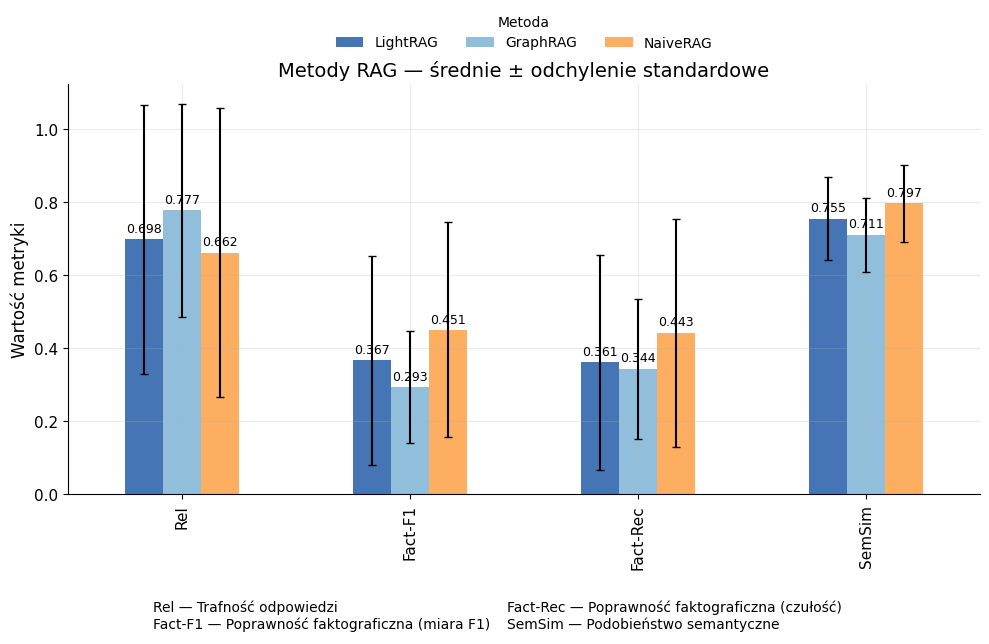

✔ Zapisano: per_method_means_with_std.png, per_method_means_with_std.svg, per_question_metrics.csv, per_question_metrics.xlsx


In [40]:
analyze("study_rules_2")

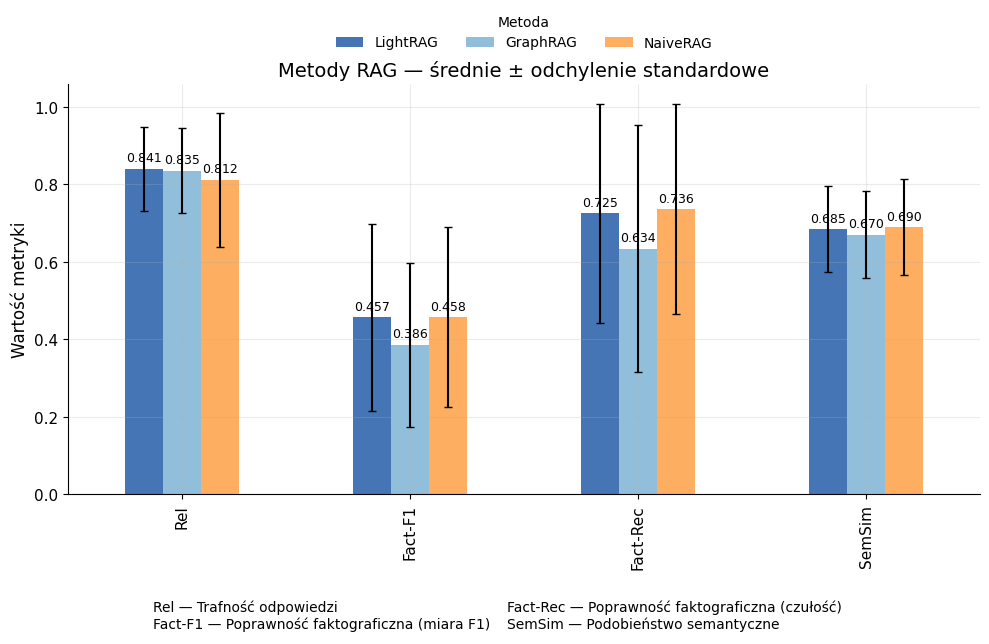

✔ Zapisano: per_method_means_with_std.png, per_method_means_with_std.svg, per_question_metrics.csv, per_question_metrics.xlsx


In [41]:
analyze("genetics")